# Figure 1 Frequency Channel Observations
In this notebook we demonstrate how to plot the timing extent of observations from the RAD1 instrument

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.transforms as transforms
import matplotlib.patches as patches
from matplotlib.ticker import MaxNLocator
import numpy as np
import vaex as vx
import itertools
from tqdm import tqdm
from Wind_Waves.plotting_tools import spectragram
from Wind_Waves.integration_tools import create_sweeps, create_spins
from Wind_Waves.reading_tools import raw2csv

# Creates a tqdm-based progressbar
def progressbar(iterable, max_value=None, **kwargs):
    """
    Wraps tqdm to keep the same API as the old `progressbar` package.

    Parameters
    ----------
    iterable : iterable
        The iterable to wrap.
    max_value : int, optional
        The total number of iterations (mapped to tqdm's `total` argument).
    **kwargs :
        Additional keyword arguments passed to tqdm.
    """
    if max_value is not None:
        return tqdm(iterable, total=max_value, **kwargs)
    else:
        return tqdm(iterable, **kwargs)

## Select Time Range

In [33]:
start, end= np.datetime64('2004-02-06T03:30')-np.timedelta64(183, 's'), np.datetime64('2004-02-06T08:00')+np.timedelta64(183, 's') # set time range

## Load Data

In [34]:
days = start+ np.arange((end.astype('datetime64[D]')-start.astype('datetime64[D]')).astype('timedelta64[D]')+1)
raw= vx.open(list((np.unique([raw2csv(date, '../../Example_Data/raw_rad1/', '../../Example_Data/raw_rad1/') for date in (days)]))))
raw.select((raw.DATETIME_Z>=start)&(raw.DATETIME_Z<=end))
sweep_start, sweep_end= raw.SWEEP.min(selection=True), raw.SWEEP.max(selection=True)
raw.select((raw.SWEEP>=sweep_start)&(raw.SWEEP<=sweep_end))

## Select First 2 Sweeps

In [35]:
raw= raw.to_pandas_df(selection=True)
raw.drop(columns=['SWEEP'], inplace=True)
create_sweeps(raw, time='Date_UTC')
create_spins(raw, spin='SPIN')
raw= raw.loc[(raw.SWEEP>0)&(raw.SWEEP<3)]

## Create Colour Mapping for Frequency Channels

In [36]:
palette = plt.cm.tab20.colors  # tuple of 10 RGBA colours
unique_vals = np.sort(raw["FREQ"].unique())
color_cycle = itertools.cycle(palette)
color_map = {val: next(color_cycle) for val in unique_vals}


## Create Figure

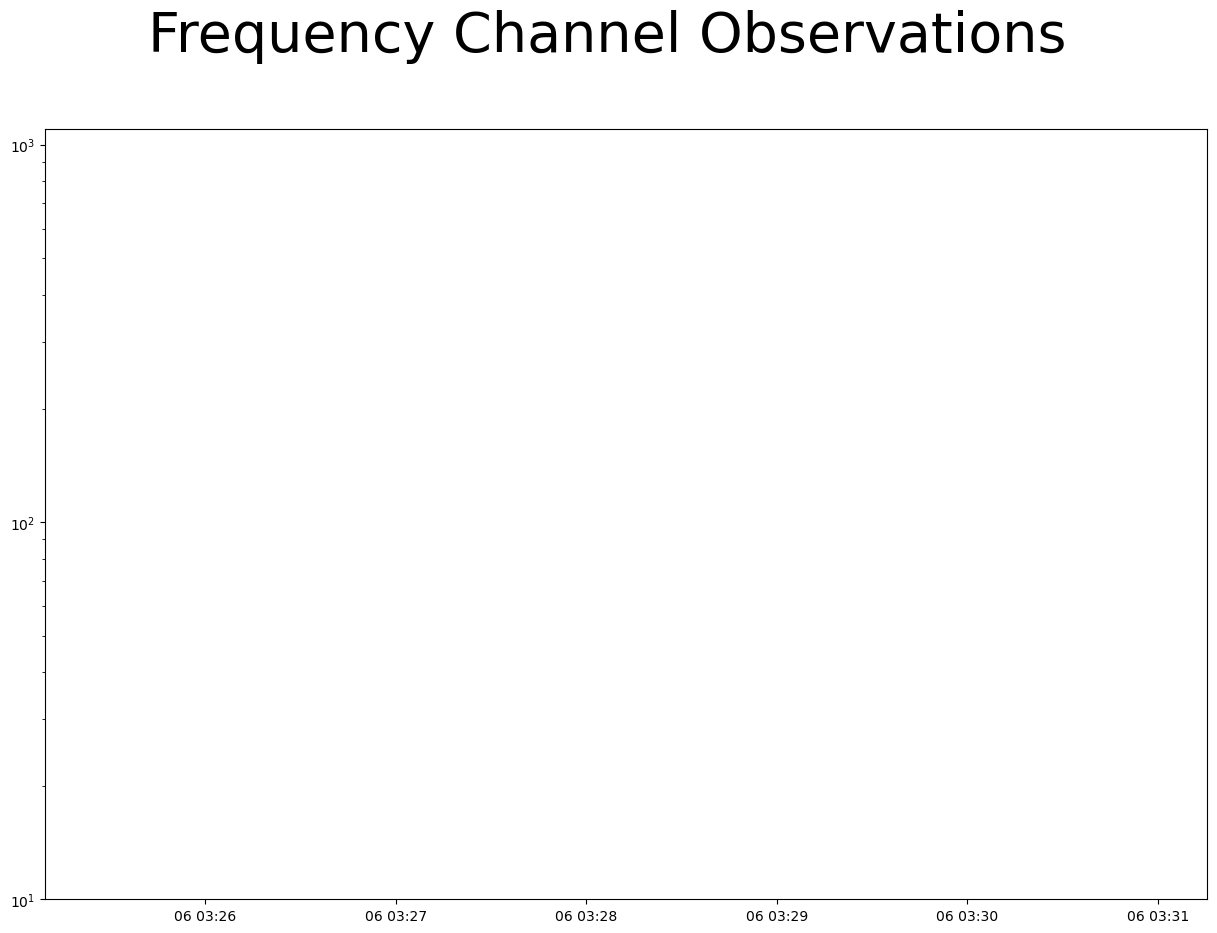

In [37]:
fig=plt.figure(figsize=(15, 10))
ax= fig.add_subplot(111)
fig.suptitle('Frequency Channel Observations', size=40, y=1.)
ax.set_ylim(10, 1100)
ax.set_xlim(raw.DATETIME_Z.min(), raw.DATETIME_Z.max())

ax.set_yscale('log')


## Set Spin Time Extent

In [38]:
width_days = 2505e-3 / (24 * 60 * 60)  # 2505 milliseconds in days


## Add Rectangles for Each Spin

100%|██████████| 1024/1024 [00:00<00:00, 2903.15it/s]


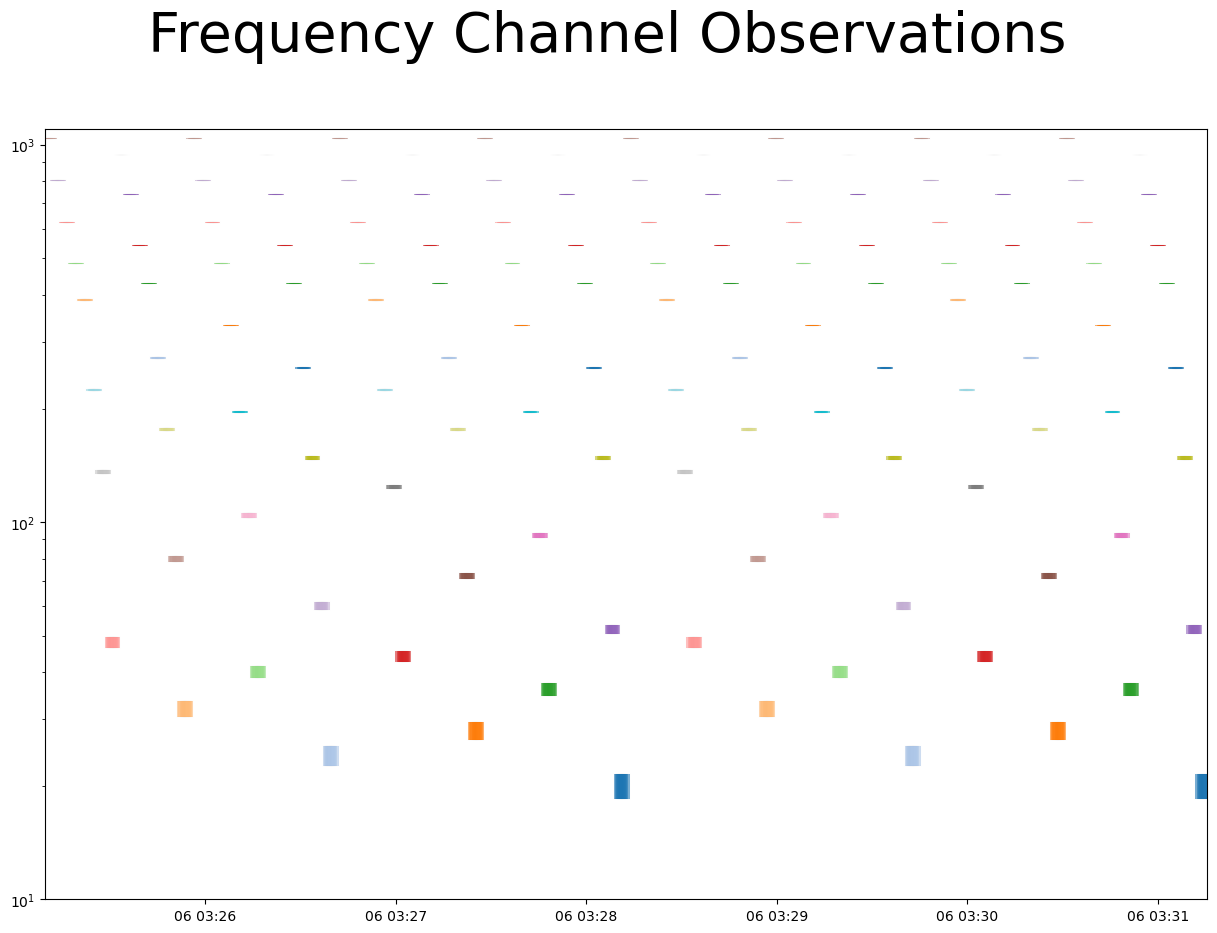

In [39]:
for xi, yi in progressbar(zip(raw.DATETIME_Z, raw.FREQ), max_value=len(raw)):
    x_center = mdates.date2num(xi)
    x0 = x_center - width_days / 2        # lower-left x
    y0 = yi - 1.5                         # lower-left y
    rect = patches.Rectangle(
        (x0, y0),
        width_days,                       # width in days
        3,                                # height in freq units
        facecolor=color_map[yi],
        alpha=0.6,
        edgecolor='black',
        lw=0.01,
    )
    ax.add_patch(rect)
fig

## Add Lines Indicating Different Frequency Channel Ranges

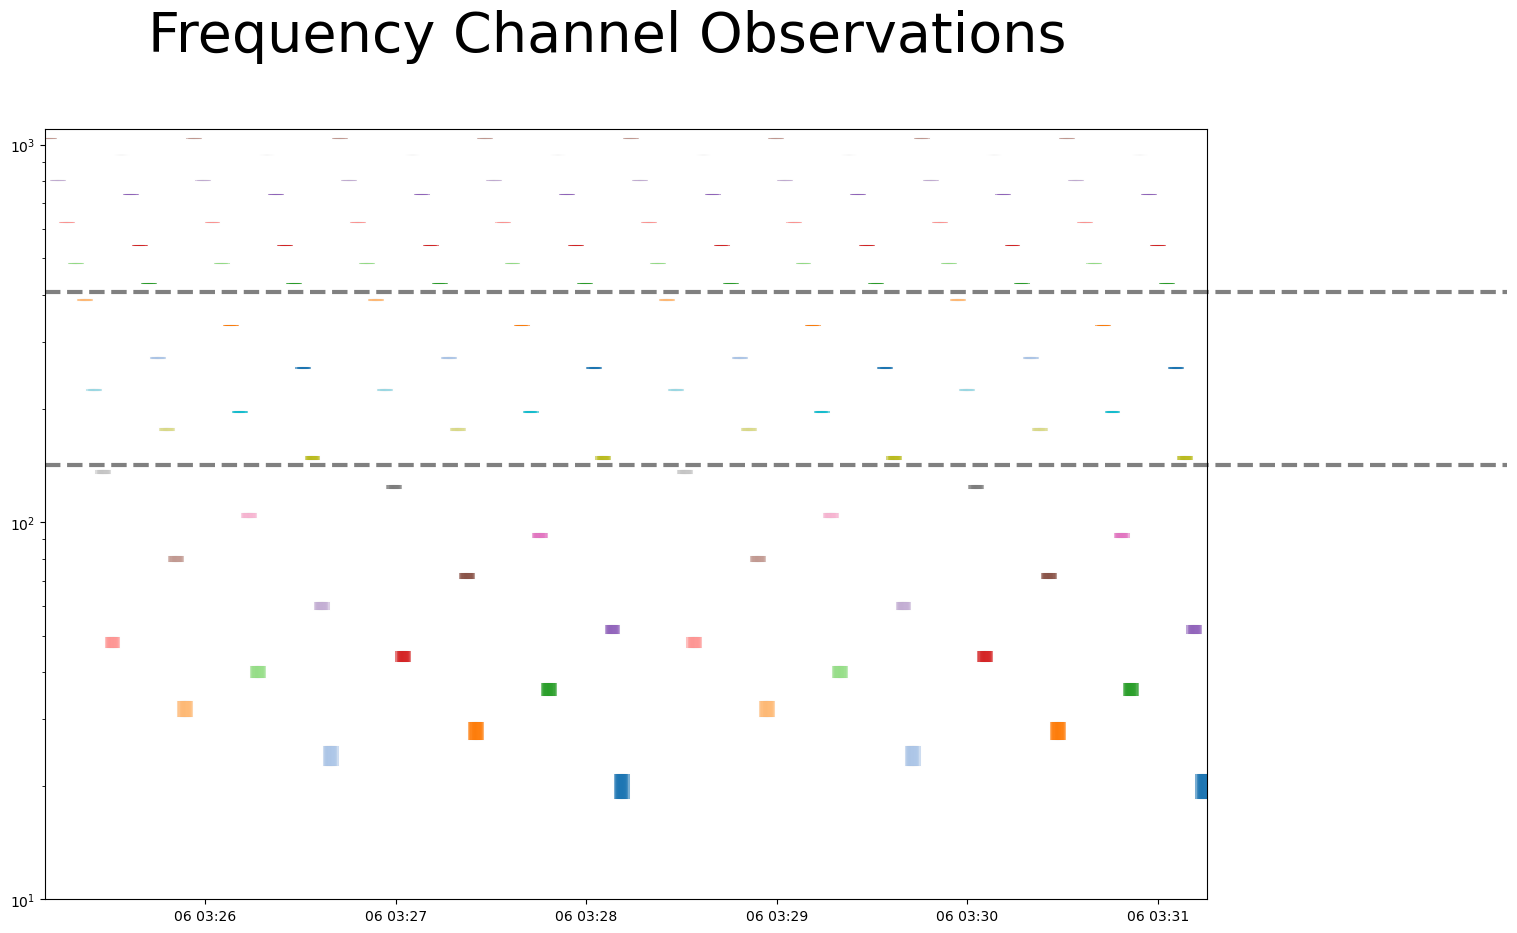

In [40]:
trans = transforms.blended_transform_factory(
    fig.transFigure,
    ax.transData)

left  = ax.get_position().x0
right = 1.1   # same x as your text label

for thresh in [142, 408]:
    ax.plot(
        [left, right],
        [thresh, thresh],
        transform=trans,
        linestyle="--",
        linewidth=3,
        color="gray",
        clip_on=False
    )
fig

## Add Number of Spins Per Sweep Text

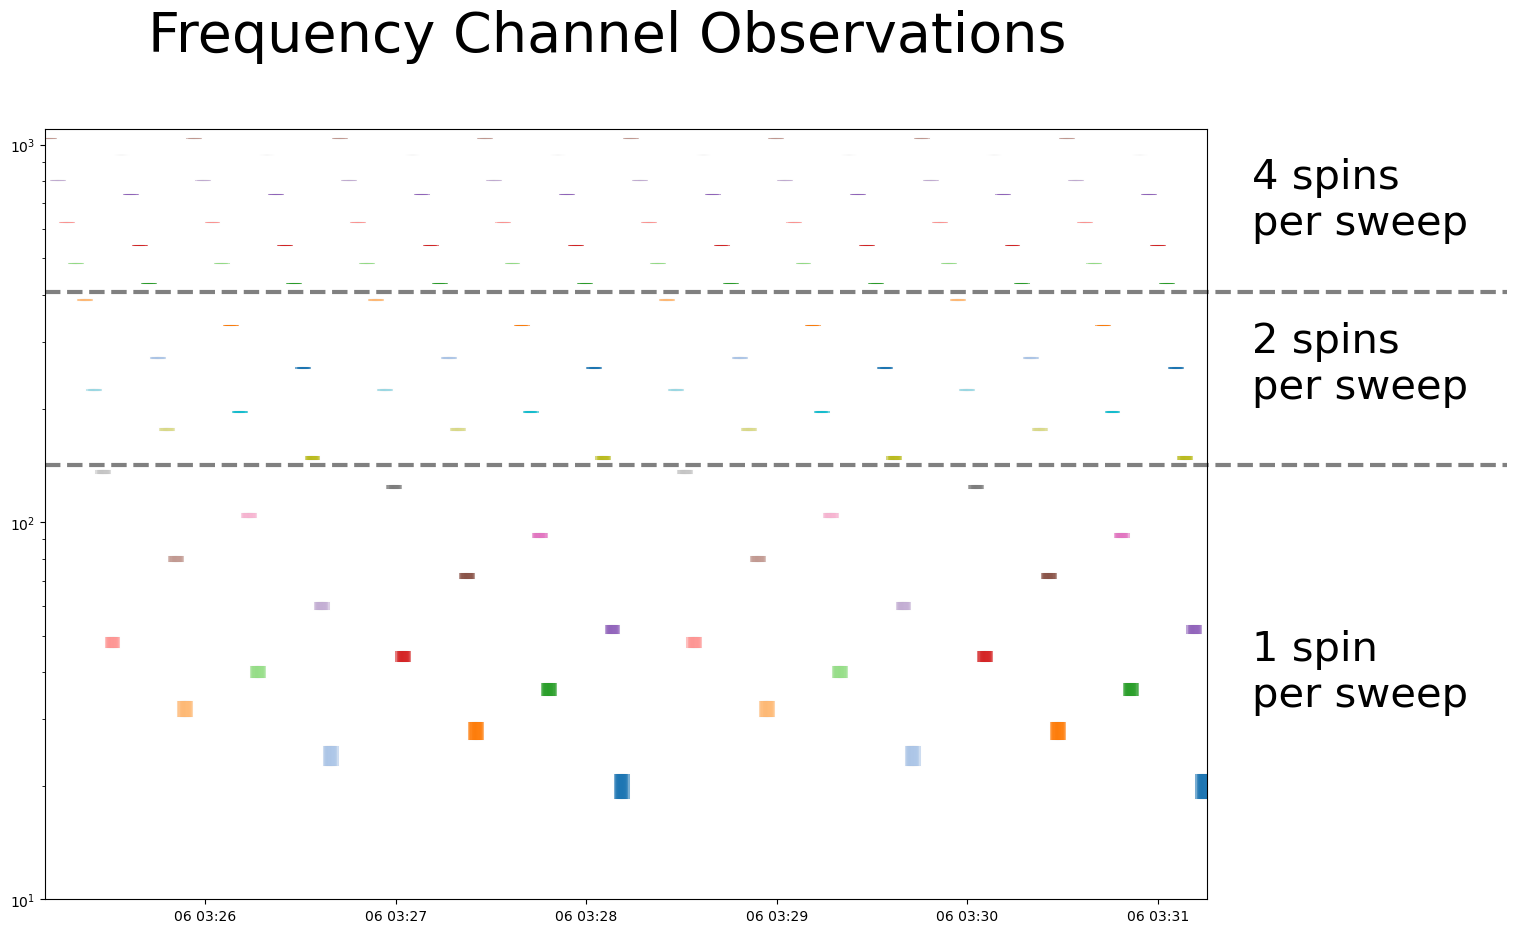

In [41]:
for thresh, n in zip([40, 136+(388-136)/2, 388+(1040-388)/2], [1, 2, 4]):
    fig.text(
    .93,
    thresh,
    f"{n} spins\nper sweep" if n>1 else f"{n} spin\nper sweep" ,
    transform=trans,
    size=30,
    va='center'
)
fig

## Add Vertical Lines to Indicate Start of Sweeps

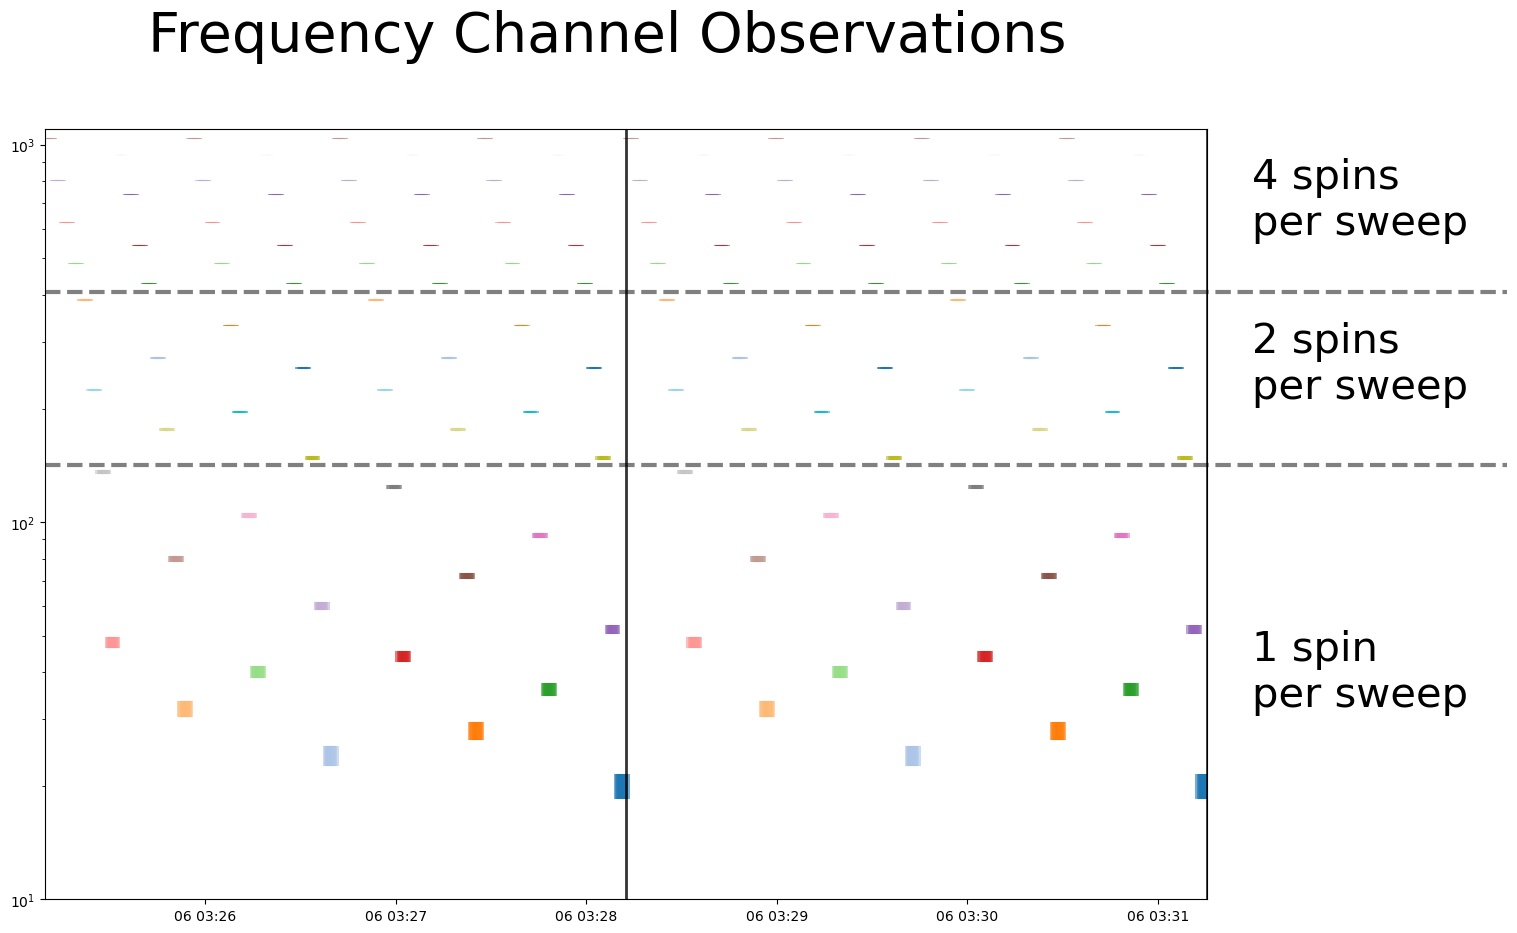

In [42]:
times = mdates.date2num([raw.DATETIME_Z.min().to_numpy(), *raw.groupby('SWEEP').DATETIME_Z.max().values])
sweeps= np.append([0], raw.SWEEP.unique())
def forward(x):
    return np.interp(x, times, sweeps)
def inverse(x):
    return np.interp(x, sweeps, times)


# 3. Map sweeps -> datetimes on the main x axis
x_grid_datetimes = [inverse(s) for s in np.arange(raw.SWEEP.min(), raw.SWEEP.max() + 1)]

for x in x_grid_datetimes:
    ax.axvline(x=x, linestyle='-', color='black', lw=2, alpha=0.8)
fig

## Create Sweep Tick Axis

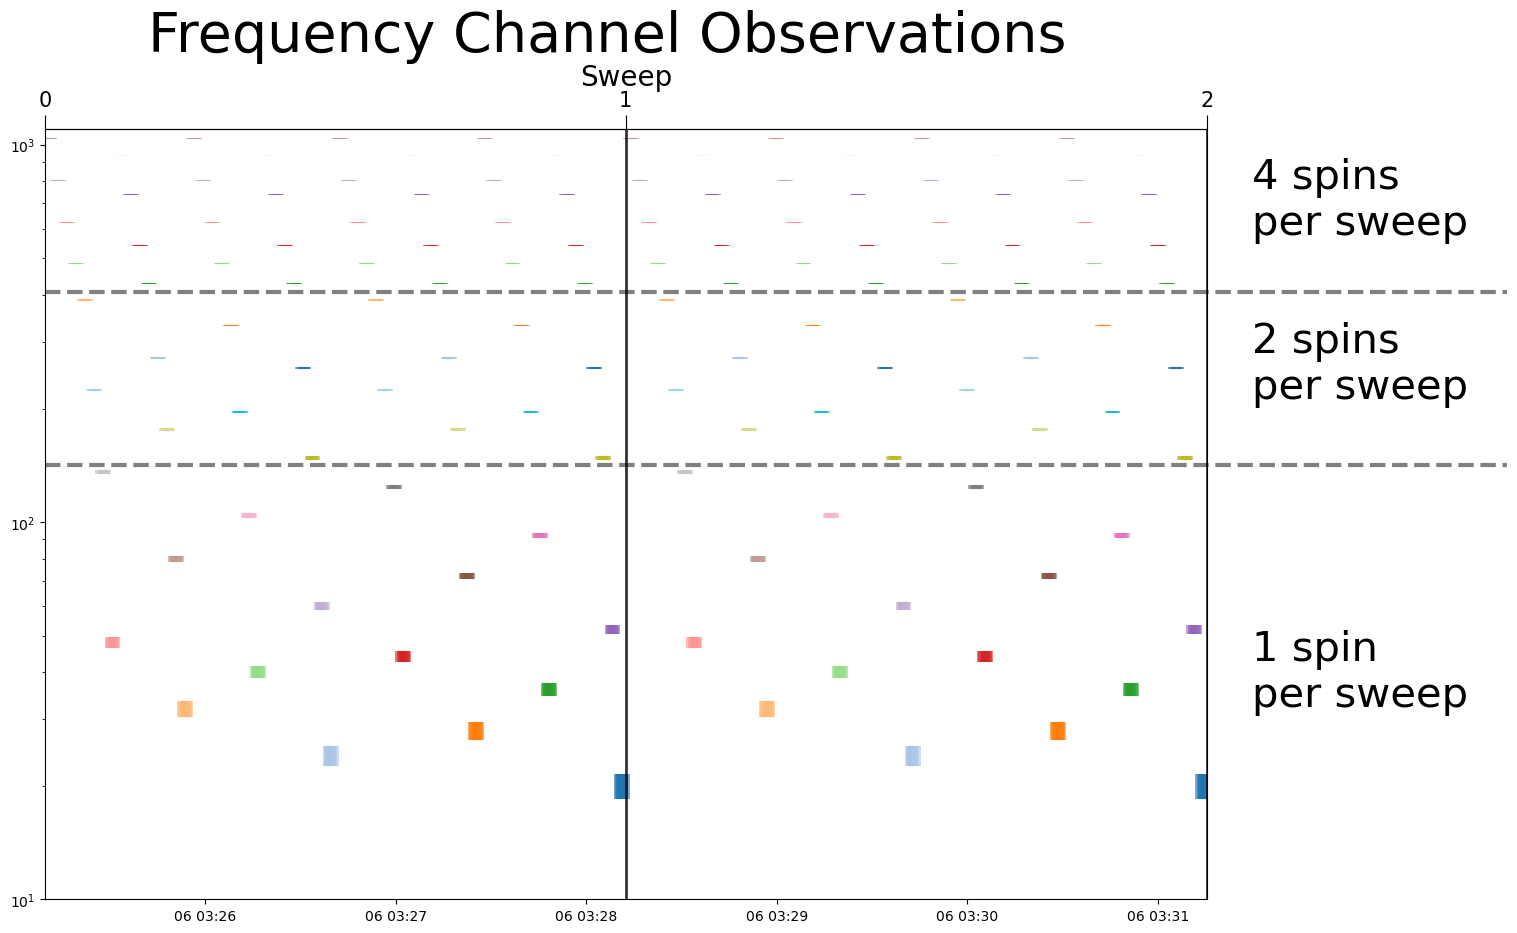

In [43]:
ax2 = ax.secondary_xaxis("top", functions=(forward, inverse))
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_xlabel('Sweep', size=20)
ax2.tick_params(axis='both', which='major', labelsize=15, size=10)
fig


## Format Main Subplot

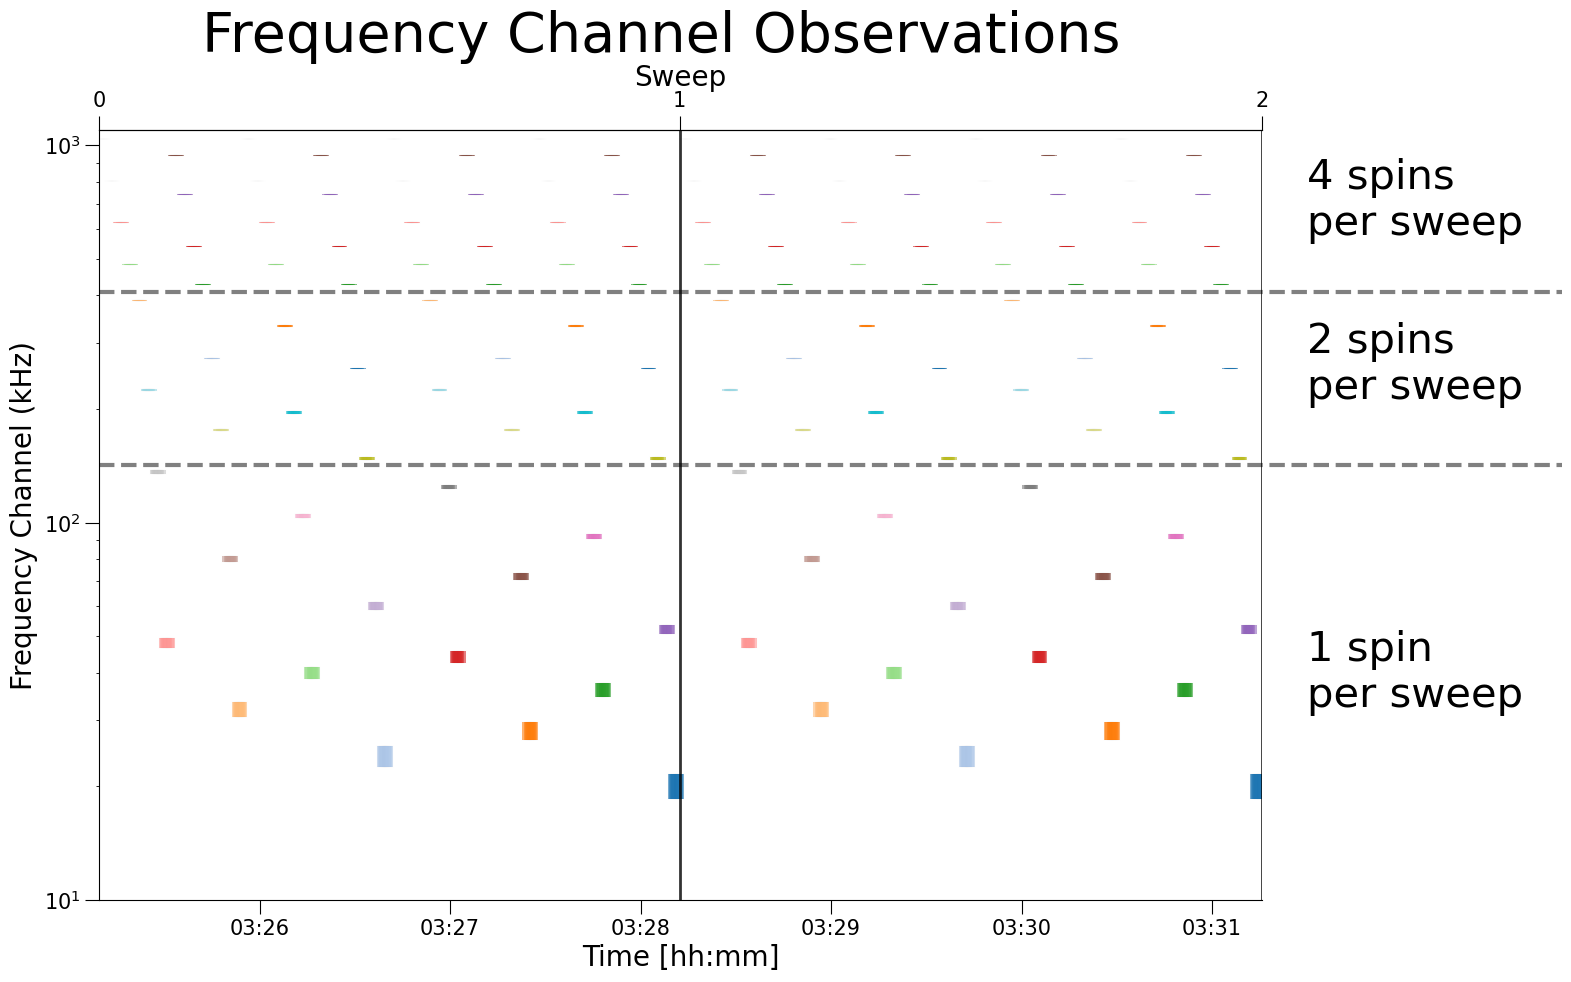

In [44]:
ax.set_xlabel('Time [hh:mm]', size=20)
ax.set_ylabel('Frequency Channel (kHz)', size=20)
ax.spines[['right']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15, size=10)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig

## Create Frequency Tick Axis

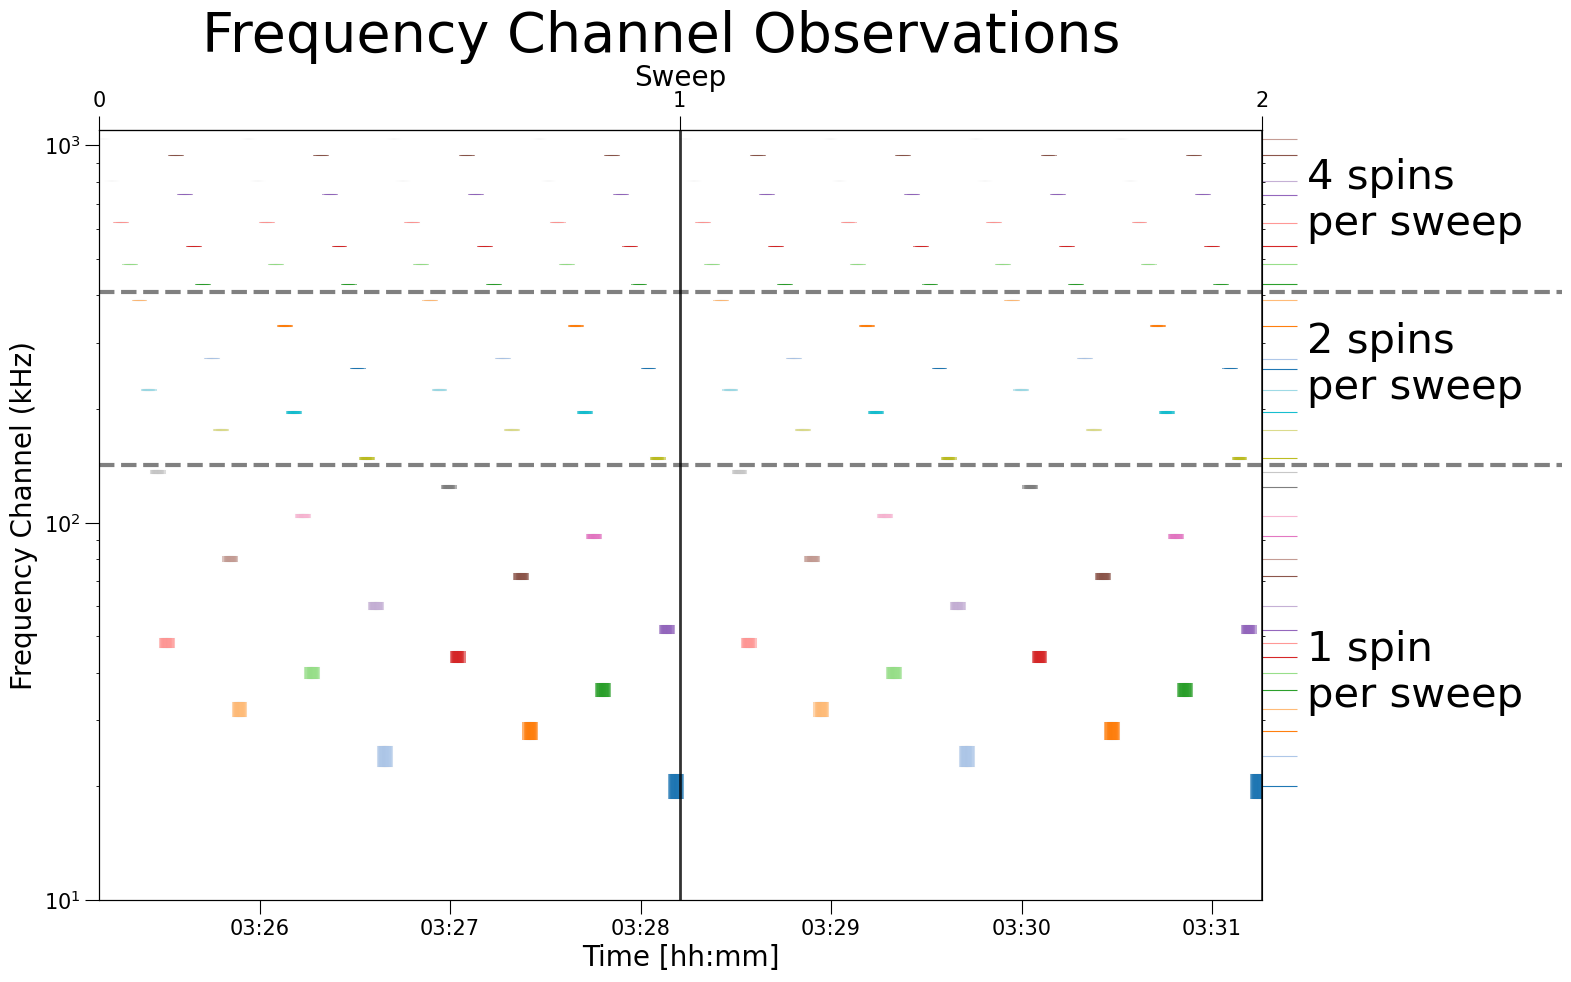

In [45]:
ax3 = ax.twinx()
ax3.set_ylim(ax.get_ylim())
ax3.set_yscale('log')
ax3.set_yticks(unique_vals)
ax3.set_yticklabels([])  # no labels, only coloured ticks
ax3.tick_params(axis='y', which='major', size=25, right=True, left=False)
# Make sure ticks exist
ax2.figure.canvas.draw_idle()
# Colour tick *lines* based on value
for mtick, val in zip(ax3.yaxis.get_major_ticks(), unique_vals):
    mtick._apply_params(color=color_map[val])
fig